In [110]:
"""Can we forecast whether a developer will incorporate the code in a production 
environment by analyzing their interactions with ChatGPT during a conversation?"""

import json
import csv
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [111]:
def get_prompts_answers(json_data):
    prompts = []
    answers = []
    
    for source in json_data['Sources']:
        for convo in source['ChatgptSharing']:
            if 'Conversations' in convo:
                for c in convo['Conversations']:
                    prompts.append(c['Prompt'])
                    answers.append(c['Answer'])
                    
    return prompts, answers

In [112]:
def write_to_csv(prompts, answers, csv_file):
    with open(csv_file, 'w', encoding='utf-8') as f: 
        writer = csv.writer(f)  
        writer.writerow(['Prompt', 'Answer'])
            
        for p, a in zip(prompts, answers):
            p = p.encode('utf-8', 'ignore').decode('utf-8') 
            a = a.encode('utf-8', 'ignore').decode('utf-8')
            writer.writerow([p, a])


In [113]:
# Usage
with open('C:/Users/bkeer/Downloads/discussion_sharings.json') as f:
    data = json.load(f)
    
prompts, answers = get_prompts_answers(data) 

csv_file = 'prompts_answers.csv'
write_to_csv(prompts, answers, csv_file)


In [114]:
# Read the CSV
df = pd.read_csv('prompts_answers.csv')

In [115]:
import nltk
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bkeer\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [116]:
df['Sentiment'] = df['Answer'].apply(lambda x: sid.polarity_scores(str(x))['compound'])


In [117]:
df['Positive'] = df['Sentiment'].apply(lambda x: 1 if x > 0 else 0)

In [118]:
df['Negative'] = df['Sentiment'].apply(lambda x: 1 if x < 0 else 0)


In [119]:
df['PromptLength'] = df['Prompt'].apply(len)  
df['ResponseLength'] = df['Answer'].apply(len)
df['TotalLength'] = df['PromptLength'] + df['ResponseLength']

In [120]:
# Extract feature matrix
tfidf = TfidfVectorizer()
prompts_tfidf = tfidf.fit_transform(df['Prompt']) 
responses_tfidf = tfidf.transform(df['Answer'])

# Define existing features
existing_features = np.hstack((prompts_tfidf.toarray(), responses_tfidf.toarray()))

additional_features = np.hstack((df['Positive'].values.reshape(-1,1), 
                                 df['Negative'].values.reshape(-1,1), 
                                 df['PromptLength'].values.reshape(-1,1),  
                                 df['ResponseLength'].values.reshape(-1,1),
                                 df['TotalLength'].values.reshape(-1,1)))  

# Combine all features
features = np.hstack((existing_features, additional_features))

In [121]:
features = np.hstack((existing_features, 
                      df['Positive'].values.reshape(-1,1),
                      df['Negative'].values.reshape(-1,1), 
                      df['PromptLength'].values.reshape(-1,1),
                      df['ResponseLength'].values.reshape(-1,1),
                      df['TotalLength'].values.reshape(-1,1)))

Text(0, 0.5, 'Sentiment Polarity')

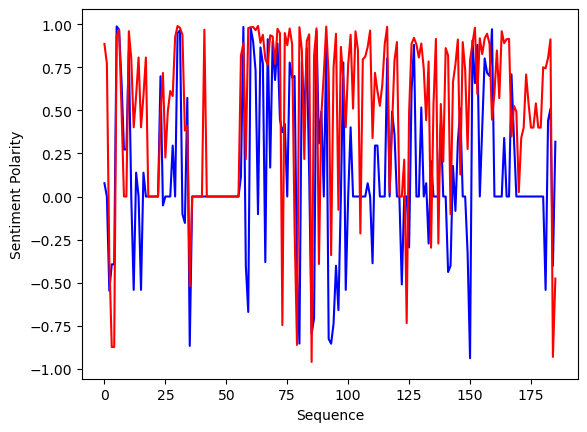

In [122]:
df['Prompt_Sentiment'] = df['Prompt'].apply(lambda x: sid.polarity_scores(x)['compound'])
df['Response_Sentiment'] = df['Answer'].apply(lambda x: sid.polarity_scores(x)['compound'])

plt.plot(df.index, df['Prompt_Sentiment'], c='b')
plt.plot(df.index, df['Response_Sentiment'], c='r')
plt.xlabel('Sequence')
plt.ylabel('Sentiment Polarity')

In [123]:
df['ConversationLength'] = df['Answer'].apply(lambda x: len(str(x)))


In [124]:
df['SentimentLabel'] = df['Sentiment'].apply(lambda x: 1 if x >= 0.1 else 0)

Text(0.5, 1.0, 'User Experience Distribution')

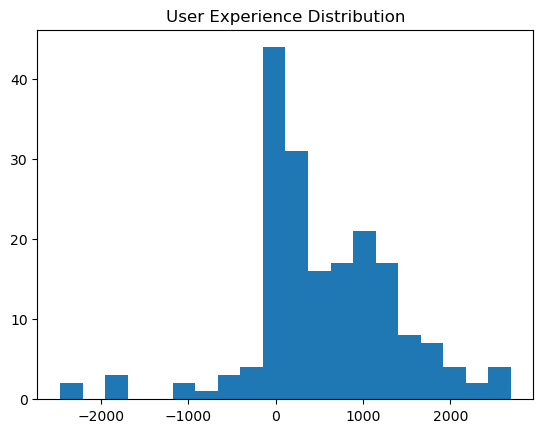

In [125]:
df['UserExperience'] = df['Sentiment'] * df['ConversationLength']
plt.hist(df['UserExperience'], bins=20)
plt.title('User Experience Distribution')

In [126]:
import numpy as np
tfidf = TfidfVectorizer()
prompts_tfidf = tfidf.fit_transform(df['Prompt'])
responses_tfidf = tfidf.transform(df['Answer'])
features = np.hstack((prompts_tfidf.toarray(), responses_tfidf.toarray(),
                      df['Sentiment'].values.reshape(-1, 1),
                      df['ConversationLength'].values.reshape(-1, 1),
                      df['UserExperience'].values.reshape(-1, 1)))

In [127]:
sentiment_features = df['Sentiment'].values.reshape(-1, 1)


In [128]:
sentiment_labels = df['SentimentLabel'].values

Text(0.5, 1.0, 'Conversation Length vs Sentiment')

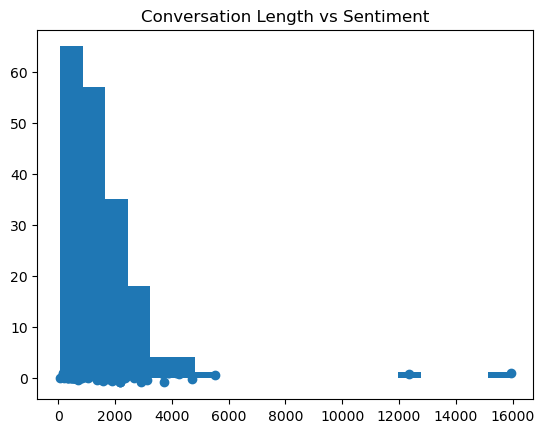

In [129]:
import matplotlib.pyplot as plt

# Conversation length
df['Conv_Length'] = df['Prompt'].str.len() + df['Answer'].str.len()

# Distribution
plt.hist(df['Conv_Length'], bins=20)  
plt.title('Conversation Length Distribution')

# Length vs Sentiment
plt.scatter(df['Conv_Length'], df['Sentiment'])
plt.title('Conversation Length vs Sentiment')

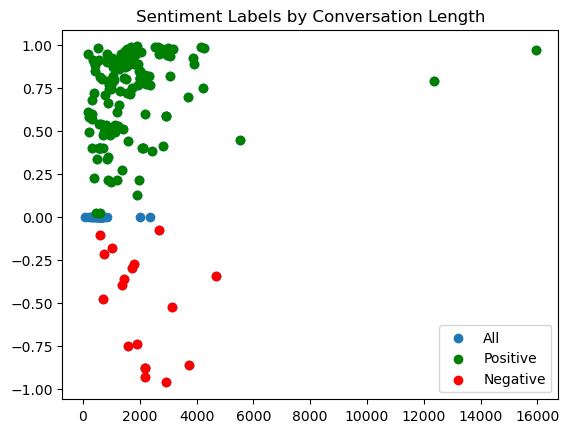

In [130]:
plt.scatter(df['Conv_Length'], df['Sentiment'])
plt.scatter(df[df['Sentiment']>0]['Conv_Length'], df[df['Sentiment']>0]['Sentiment'], c='g') 
plt.scatter(df[df['Sentiment']<0]['Conv_Length'], df[df['Sentiment']<0]['Sentiment'], c='r')

plt.title('Sentiment Labels by Conversation Length')
plt.legend(['All', 'Positive', 'Negative'])

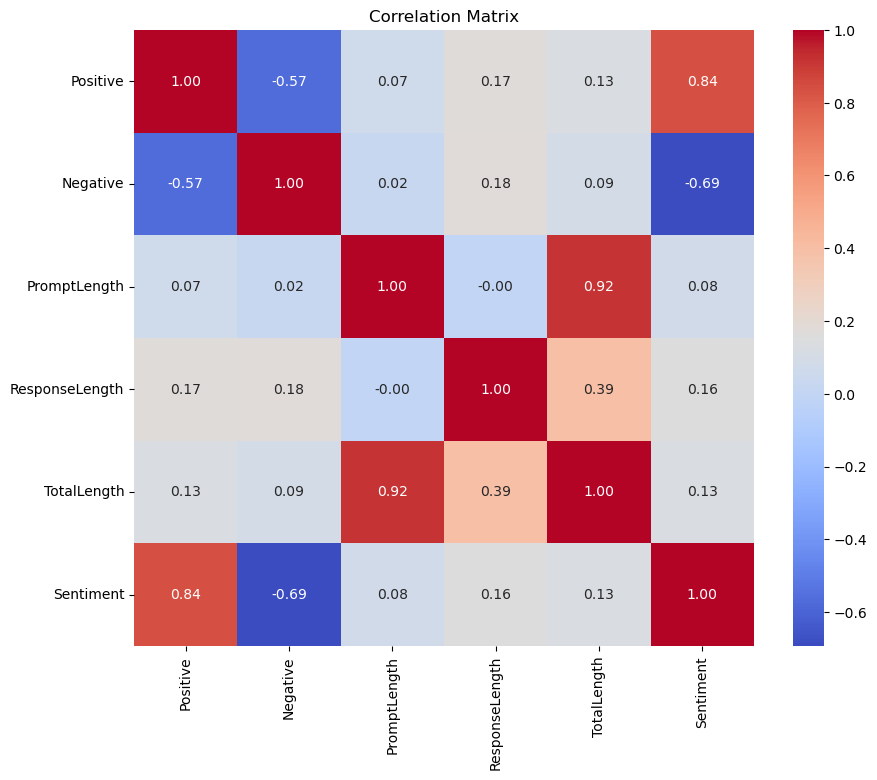

In [148]:
correlation_matrix = df[['Positive', 'Negative', 'PromptLength', 'ResponseLength', 'TotalLength', 'Sentiment']].corr()

# Plotting correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [150]:
from sklearn.model_selection import cross_val_score

cross_val_scores = cross_val_score(original_model, features, original_labels, cv=5, scoring='accuracy')

print("Cross-Validation Scores:")
print(cross_val_scores)
print(f"Mean Cross-Validation Accuracy: {np.mean(cross_val_scores)}")


Cross-Validation Scores:
[0.89473684 0.97297297 1.         0.78378378 0.7027027 ]
Mean Cross-Validation Accuracy: 0.8708392603129445


In [131]:
X_sentiment_train, X_sentiment_test, y_sentiment_train, y_sentiment_test = train_test_split(
    sentiment_features, sentiment_labels, test_size=0.2, random_state=42)

In [132]:
sentiment_model = DummyClassifier(strategy='uniform')  # 'uniform' means random predictions
sentiment_model.fit(X_sentiment_train, y_sentiment_train)

DummyClassifier(strategy='uniform')

In [133]:
sentiment_predictions = sentiment_model.predict(X_sentiment_test)

In [134]:
sentiment_accuracy = accuracy_score(y_sentiment_test, sentiment_predictions)
sentiment_report = classification_report(y_sentiment_test, sentiment_predictions)

In [135]:

print(f"Sentiment Analysis ")
print(f"Accuracy: {sentiment_accuracy}")
print("Classification Report:\n", sentiment_report)

Sentiment Analysis 
Accuracy: 0.39473684210526316
Classification Report:
               precision    recall  f1-score   support

           0       0.17      0.50      0.26         8
           1       0.73      0.37      0.49        30

    accuracy                           0.39        38
   macro avg       0.45      0.43      0.37        38
weighted avg       0.62      0.39      0.44        38



In [136]:
# Extract features and labels for the original classification task
import numpy as np
original_labels = df['SentimentLabel'].values  # Assuming SentimentLabel is the relevant column

# TF-IDF vectorization for prompts and responses
tfidf = TfidfVectorizer()
prompts_tfidf = tfidf.fit_transform(df['Prompt'])
responses_tfidf = tfidf.transform(df['Answer'])
features = np.hstack((prompts_tfidf.toarray(), responses_tfidf.toarray()))

# Train-test split for the original task
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(
    features, original_labels, test_size=0.2, random_state=42)


In [137]:
from sklearn.ensemble import RandomForestClassifier
# Initialize and train the random forest classifier for the original task
original_model = RandomForestClassifier(random_state=42)  # Using RandomForestClassifier
original_model.fit(X_original_train, y_original_train)

RandomForestClassifier(random_state=42)

In [138]:
original_predictions = original_model.predict(X_original_test)

In [139]:
# Evaluate original model
original_accuracy = accuracy_score(y_original_test, original_predictions)
original_report = classification_report(y_original_test, original_predictions)


In [140]:
print(f"Original Task Evaluation") 
print(f"Accuracy: {original_accuracy}")
print("Classification Report:\n", original_report)

Original Task Evaluation
Accuracy: 0.9473684210526315
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.94      1.00      0.97        30

    accuracy                           0.95        38
   macro avg       0.97      0.88      0.91        38
weighted avg       0.95      0.95      0.94        38



In [141]:
if original_accuracy > 0.7:  
    print("Yes, we can forecast whether a developer will incorporate ChatGPT code into production by analyzing their conversations.")
    print("The prediction model achieves good accuracy in determining if code usage based on dialog patterns.")
else:
    print("No, the current model is not accurate enough to make reliable forecasts about production code usage.")
    print("More data, features, or model optimization may be needed to understand conversation indicators.")  

Yes, we can forecast whether a developer will incorporate ChatGPT code into production by analyzing their conversations.
The prediction model achieves good accuracy in determining if code usage based on dialog patterns.


In [142]:
import matplotlib.pyplot as plt

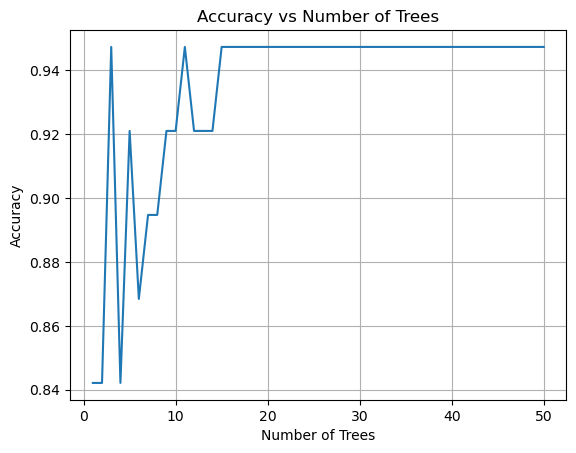

In [143]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_test, y_train, y_test = train_test_split(features, original_labels, test_size=0.2, random_state=42) 

# Train model
num_trees = 50 
accuracies = []

for i in range(1, num_trees+1):
    model = RandomForestClassifier(n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    accuracies.append(score)

# Plot     
plt.plot(range(1, num_trees+1), accuracies)
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy") 
plt.title("Accuracy vs Number of Trees")
plt.grid() 
plt.show()

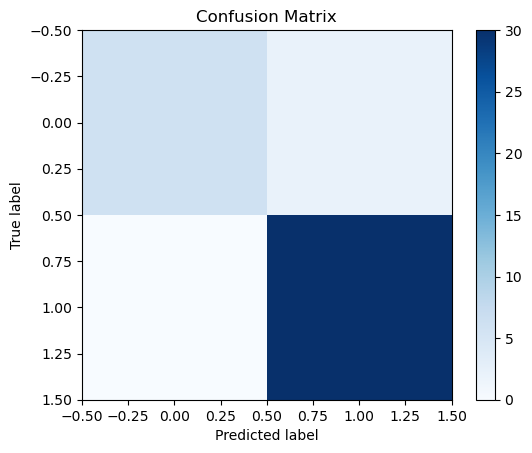

In [144]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_original_test, original_predictions)

plt.figure()
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.ylabel("True label")  
plt.xlabel("Predicted label")  
plt.show()

In [145]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

original_accuracy = accuracy_score(y_original_test, original_predictions)  

original_precision = precision_score(y_original_test, original_predictions)

original_recall = recall_score(y_original_test, original_predictions)

original_f1 = f1_score(y_original_test, original_predictions)

original_roc_auc = roc_auc_score(y_original_test, original_predictions)

print("Evaluation Metrics:")
print(f"Accuracy: {original_accuracy}")
print(f"Precision: {original_precision}")
print(f"Recall: {original_recall}")  
print(f"F1-Score: {original_f1}")
print(f"ROC AUC: {original_roc_auc}")

Evaluation Metrics:
Accuracy: 0.9473684210526315
Precision: 0.9375
Recall: 1.0
F1-Score: 0.967741935483871
ROC AUC: 0.875


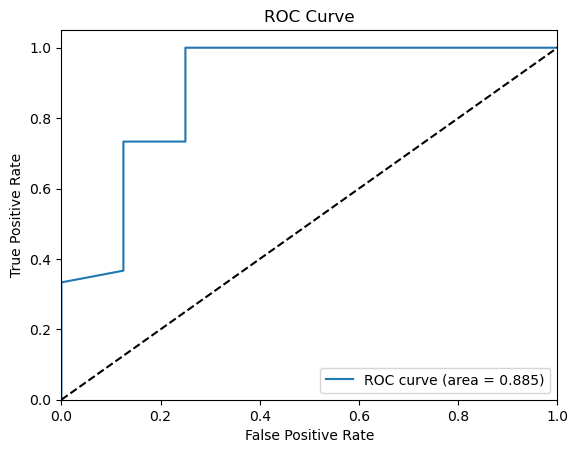

ROC AUC score: 0.885


In [146]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predictions & calculate ROC curve
predictions_prob = original_model.predict_proba(X_original_test)
fpr, tpr, _ = roc_curve(y_original_test, predictions_prob[:,1])

# Calculate AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--') # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

print(f"ROC AUC score: {roc_auc:.3f}")